In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_parquet("sigmod_merged.parquet")

In [4]:
df = df[~df.operator.apply(lambda operator_str: any([x in operator_str for x in ['Materialization', 'Noop']]))]

In [5]:
# handle failures
df['operator_original'] = df.operator
df['operator']= df.operator.apply(lambda operator_str: operator_str.split("= fail:")[0])
scalar_ops = ['Left multiply', 'Row summation' , 'Column summation' , 'Left multiply T' , 'Row summation T', 'Column summation T', 'Right multiply','Right multiply T']
df['operator_type'] = df.operator.apply(lambda operator_str: 'scalar' if operator_str in scalar_ops else operator_str)

In [6]:
from collections import defaultdict
materialized_complexity_dict = defaultdict(lambda: 0)
for dataset, operator, complexity in df[df.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
    materialized_complexity_dict[(dataset, operator)] = complexity

def calc_complexity_ratio(row):
    if row[1] == 'Materialization':
        return None
    val = materialized_complexity_dict[(row[0], row[1])]
    if not val:
        return None
    return  val/ row[2]

df['complexity_ratio'] = df[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

In [7]:
baseline_lookup_dict = {(dataset, operator, num_cores): mean_time for (dataset, operator, num_cores, mean_time) in df[((df.model == 'materialized') | (df.model == 'baseline'))][['dataset', 'operator', 'num_cores', 'times_mean']].values}
def calc_speedup(row) -> float:
    if row[1] == 'Materialization':
        return 0.0
    baseline = baseline_lookup_dict[(row[0], row[1], row[2])]
    return baseline / row[3]

df['speedup'] = df[['dataset', 'operator', 'num_cores', 'times_mean']].apply(calc_speedup, axis=1)

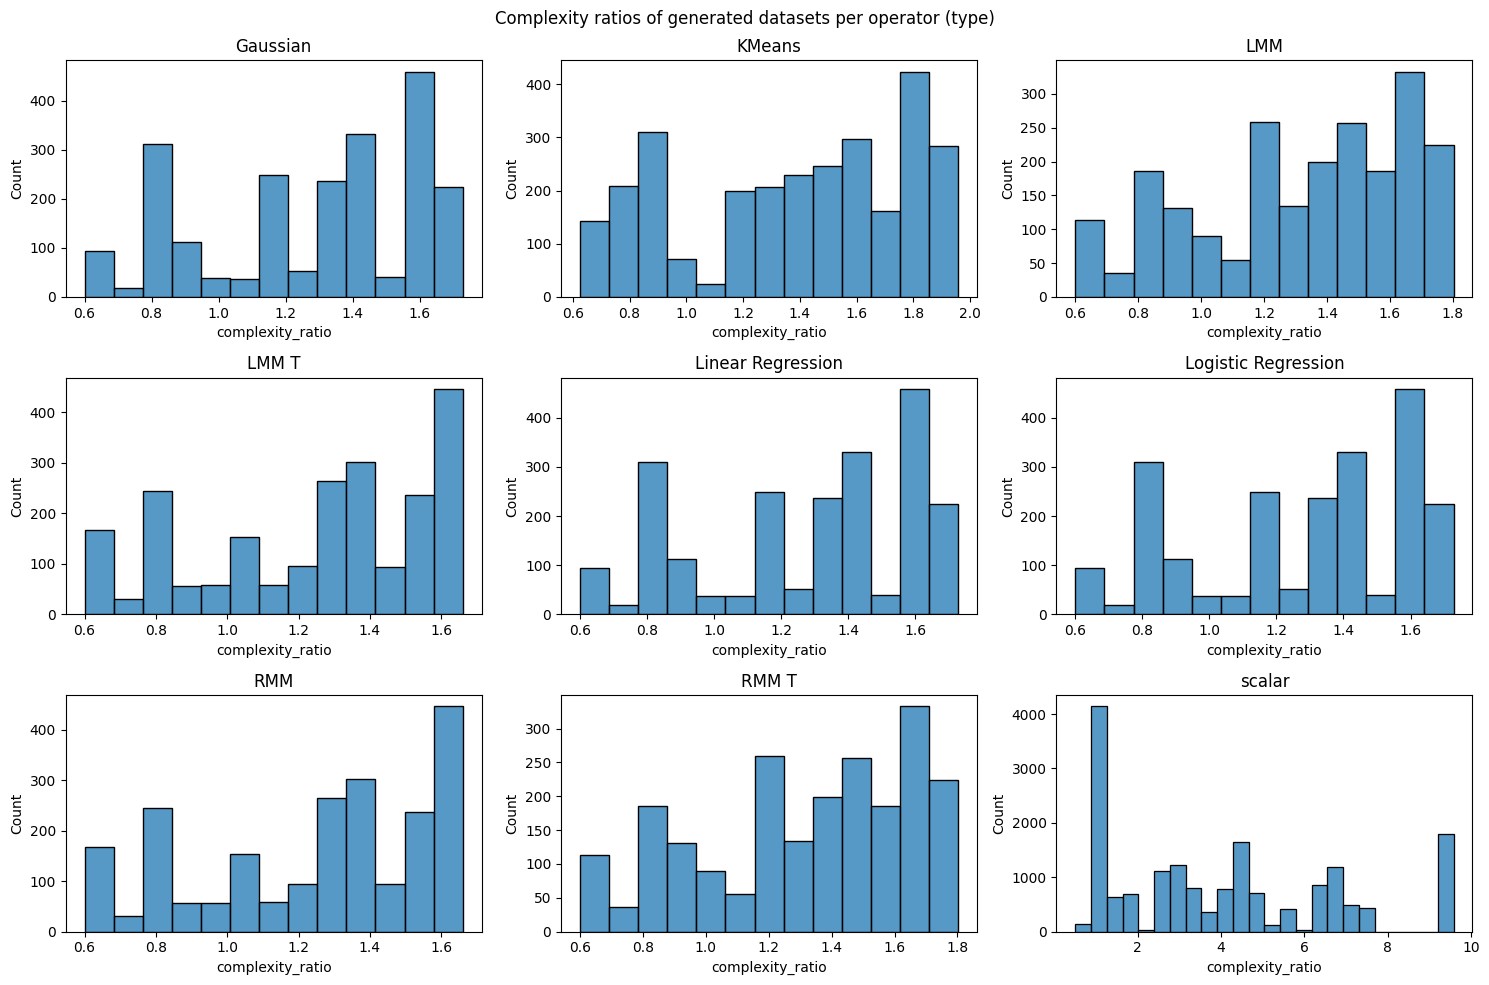

In [8]:
fig, axs = plt.subplots((len(df.operator_type.unique()))//3, 3,figsize=(15, 10), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.4, top=0.85)

axs = axs.flatten()
for ax, (group, dfsub) in zip(axs, df[df.model!='materialized'].groupby('operator_type')):
    sns.histplot(data=dfsub, x='complexity_ratio', ax=ax)
    ax.set_title(group)
fig.suptitle("Complexity ratios of generated datasets per operator (type)")
plt.tight_layout()
plt.savefig('fig.png')

## Per operator type (Scalar, elementwise & ML) show speedup ratio versus complexity ratio

In [26]:
df = df[df.model == 'factorized'].copy()

In [27]:
SCALAR = 0
ELEMENTWISE=1
ML = 2

# TODO split up sum and multiply?
def get_operator_type_int(operator: str) -> int:
    match operator:
        case "KMeans" | "Gaussian" | "Logistic Regression" | "Linear Regression":
            return ML
        case "scalar": 
            return SCALAR
        case _:
            return ELEMENTWISE

def round_complexity_ratio(row):
    n_dec = 0 if row[1] == SCALAR else 1
    return round(row[0], n_dec)


df['operator_type_int'] = df.operator_type.apply(get_operator_type_int)
df['complexity_ratio_rounded'] = df[['complexity_ratio', 'operator_type_int']].apply(round_complexity_ratio, axis=1)

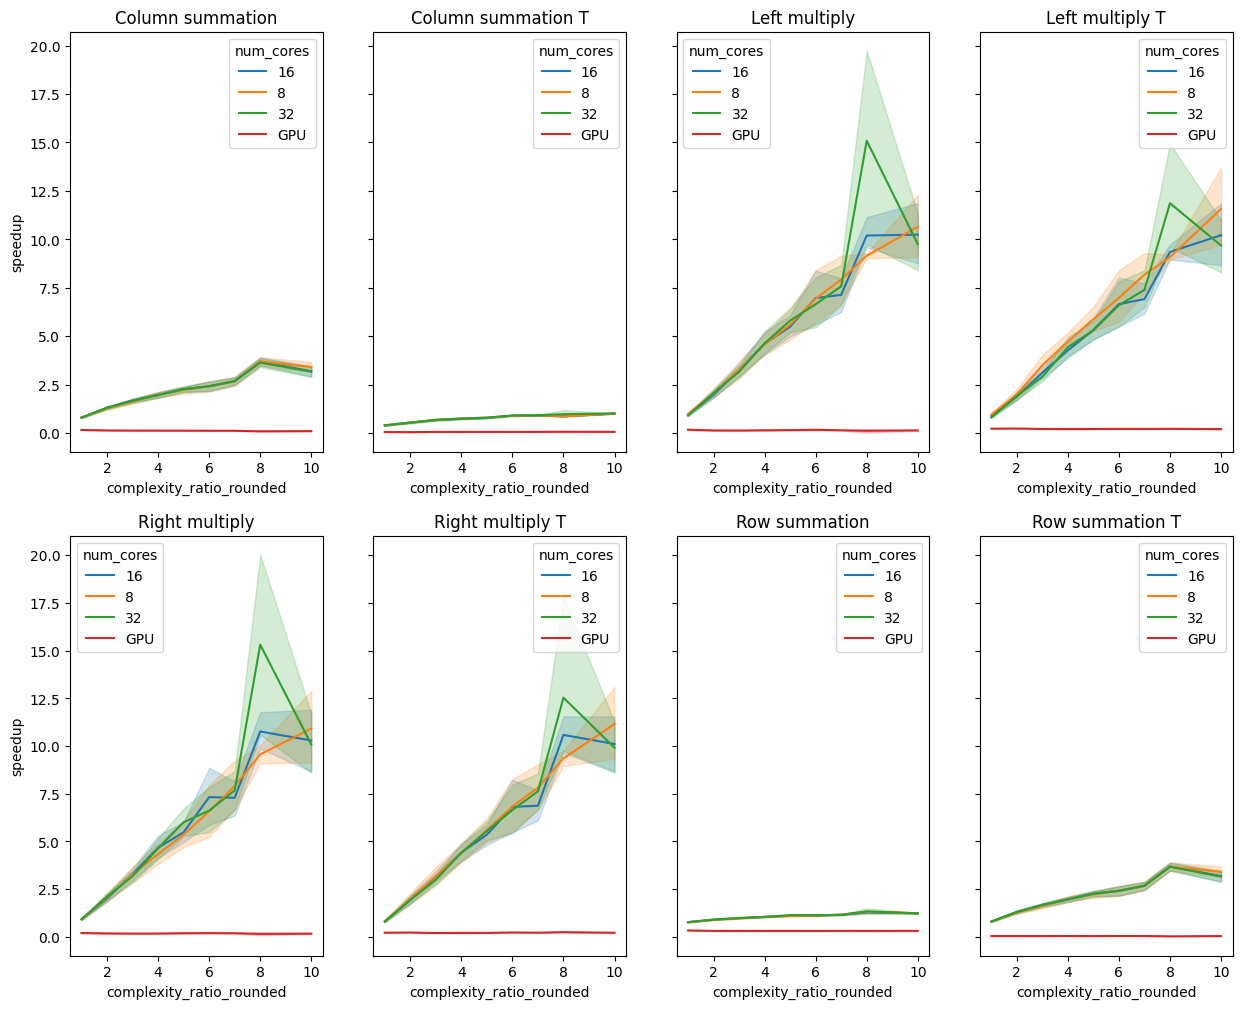

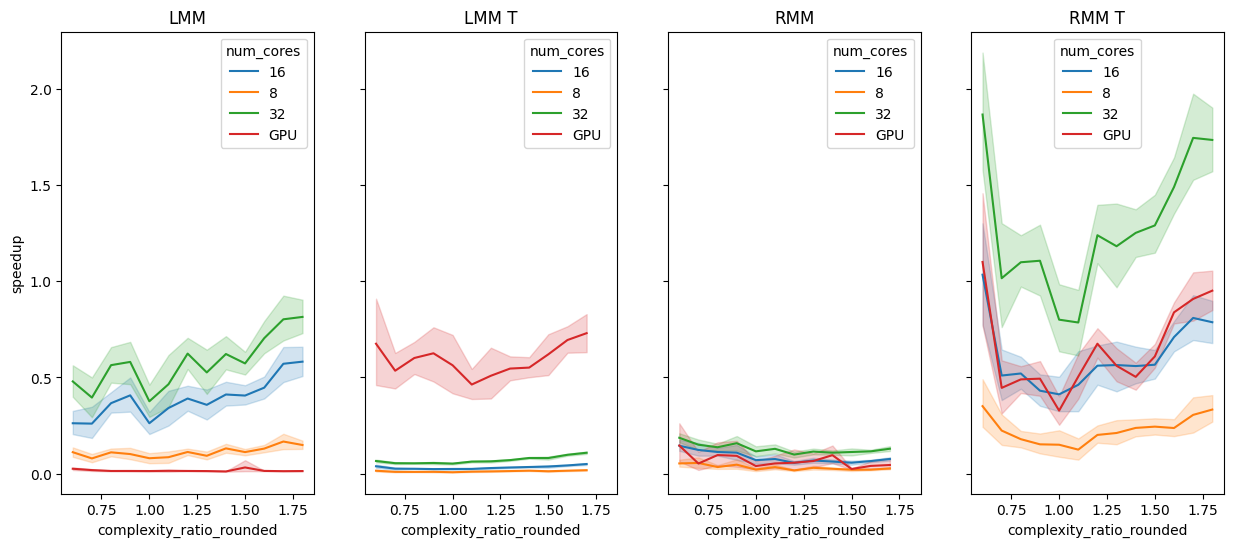

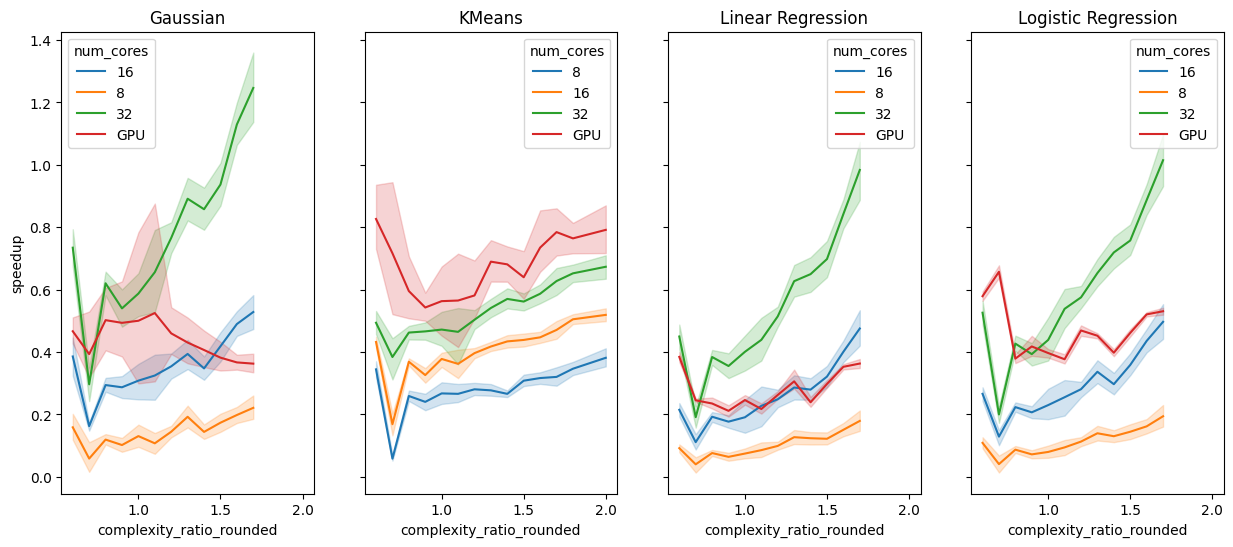

In [28]:
for op_group, group_df in df.groupby("operator_type_int"):
    # create fig, axs 
    rows = len(group_df.operator.unique())//4
    fig, axs = plt.subplots(nrows=rows, ncols=4, sharex='row', sharey='row', figsize=(15, 6*rows))
    for ax, (operator, dfsub) in zip(axs.flat, group_df.groupby("operator")):
        sns.lineplot(data=dfsub, x='complexity_ratio_rounded', y='speedup', ax=ax, hue='num_cores')
        ax.set_title(operator)